In [1]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
using StatsPlots

In [2]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [41]:
# Modified for mutli-signal to return times instead of time-crops
# Smooth signal for finding half-max time to exclude noisy peaks
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

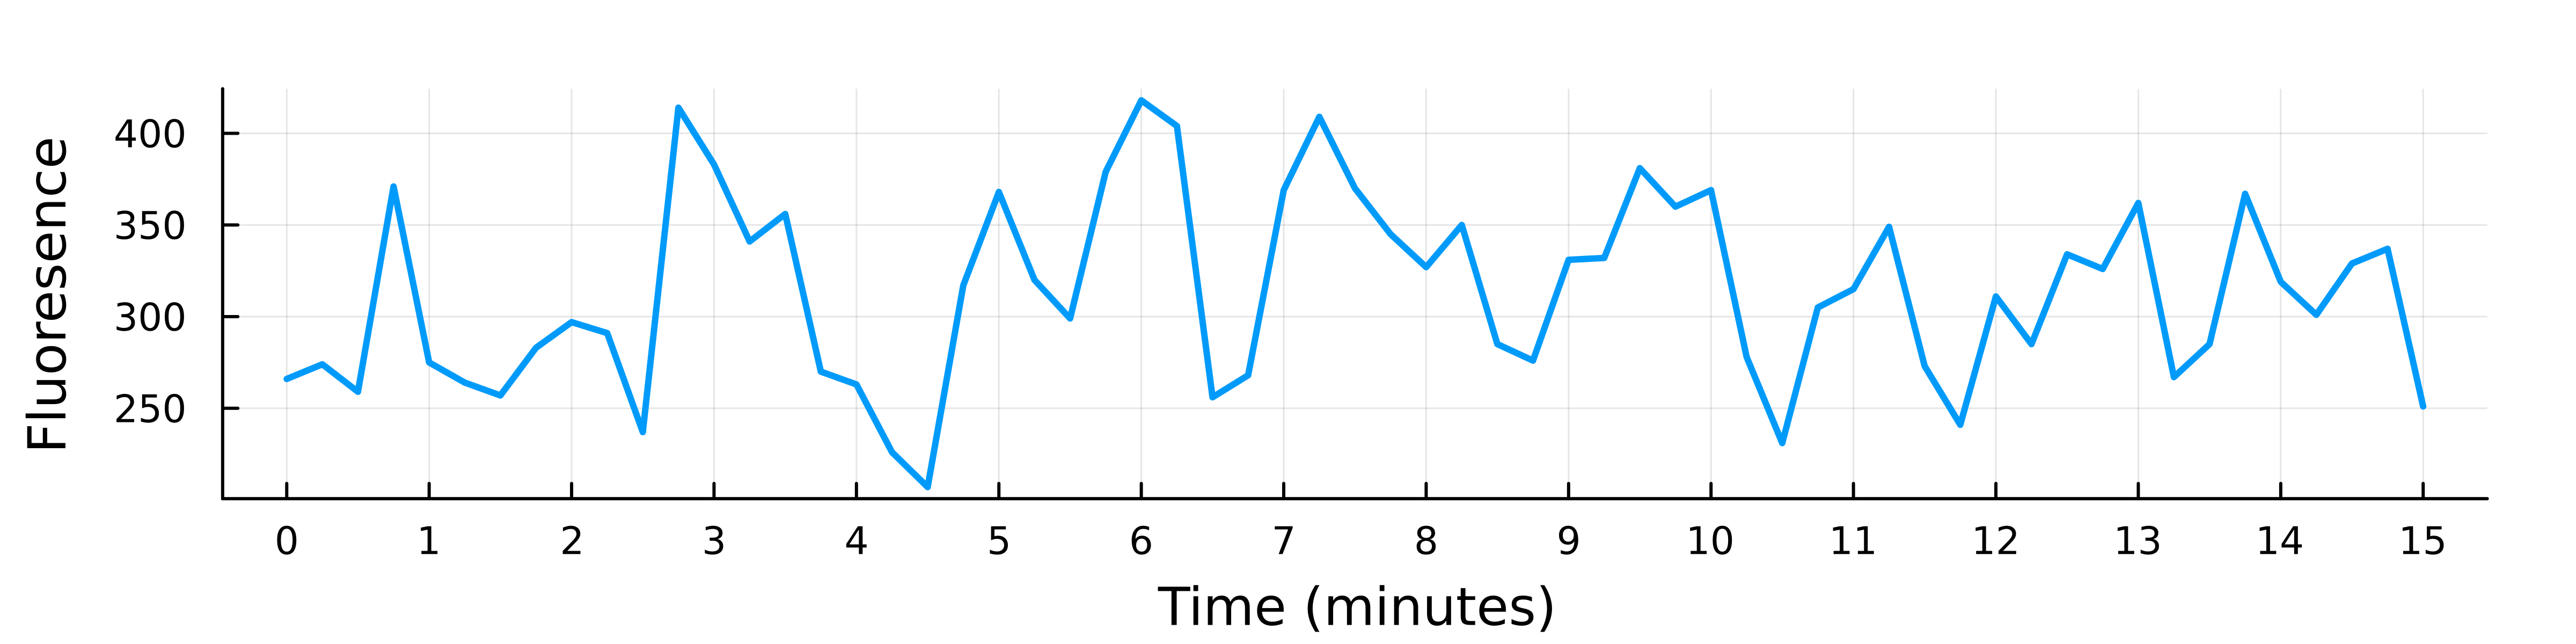

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [93]:
file = "../data/movies-rga-bem3-cdc42/bem3/cell1.tif"

interval = 15
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
crop1 = q1[times_max1]
t = range(0,60/interval*15)*(interval/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGB_1site_m3c21.png")

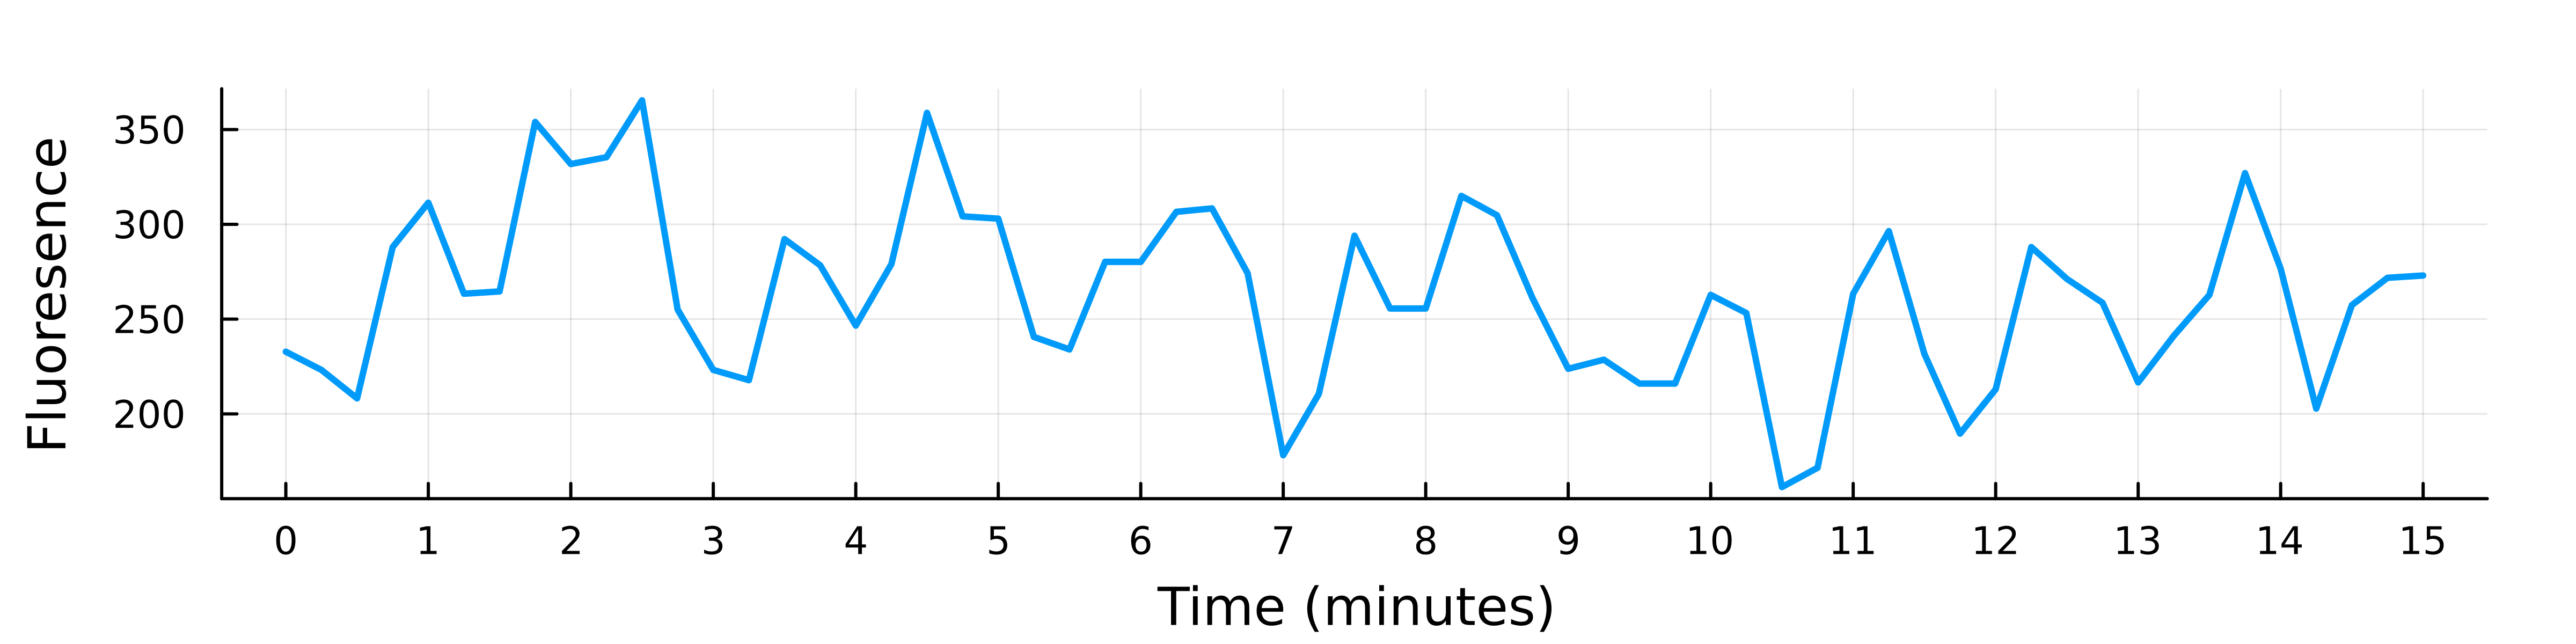

In [43]:
file = "../data/movies-rga-bem3-cdc42/cdc42/cell1.tif"

interval = 15
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
crop1 = q1[times_max1]
t = range(0,60/interval*15)*(interval/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1.*(3/5), xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGB_1site_m3c21.png")

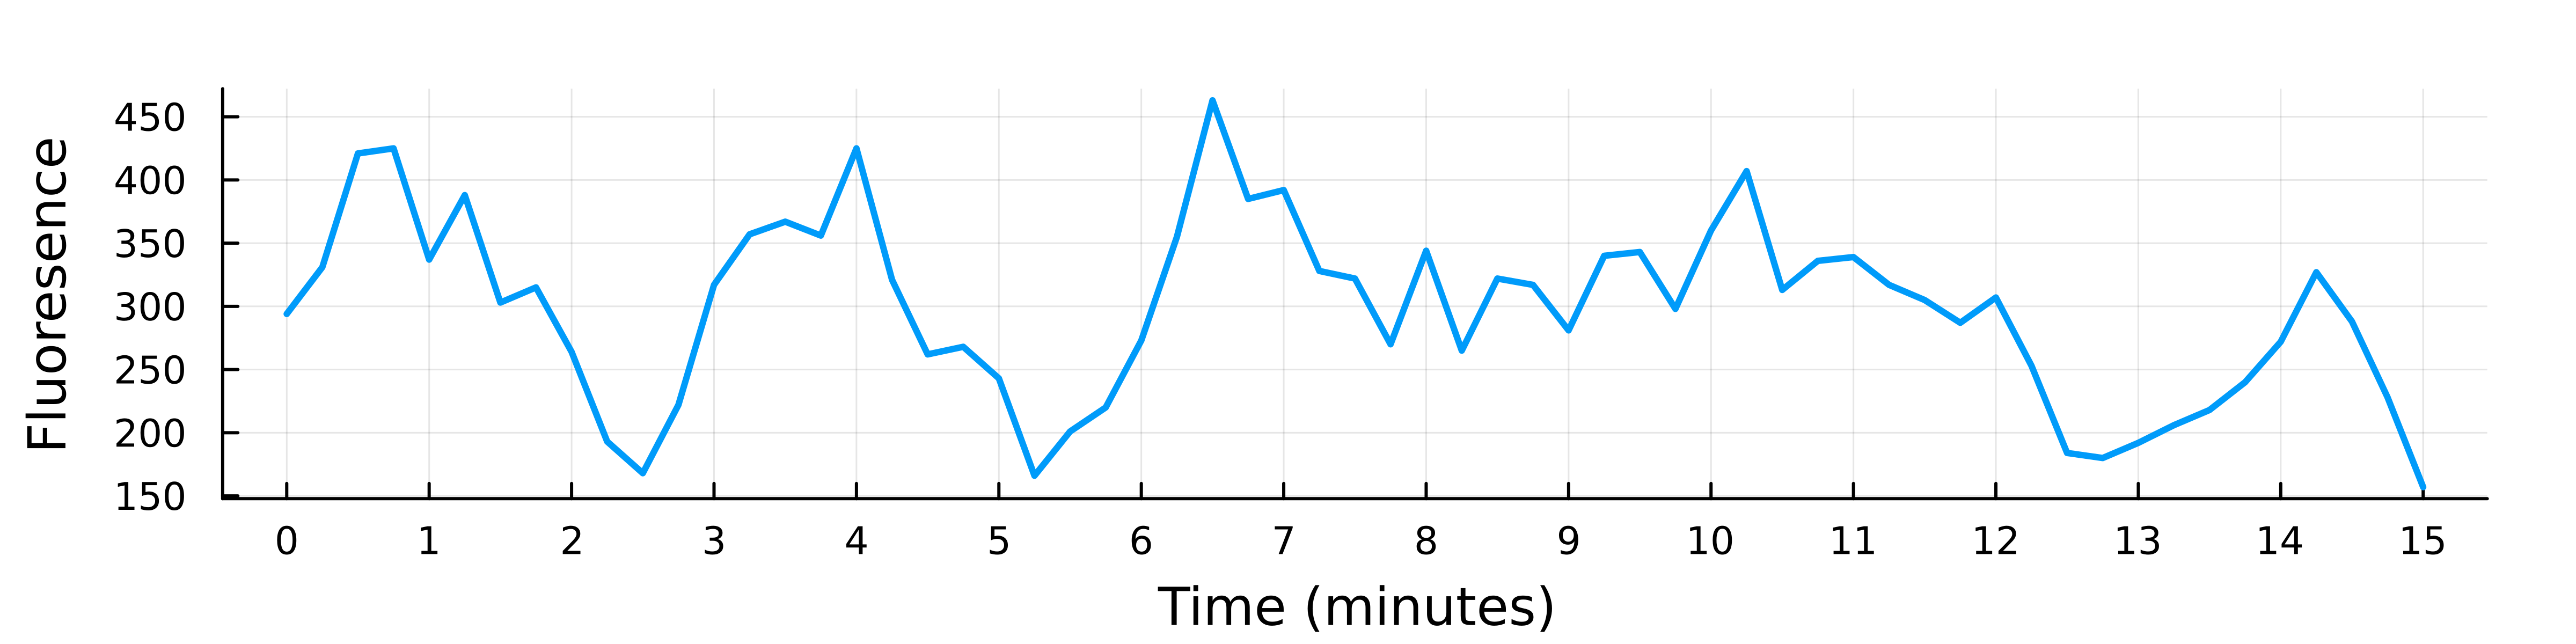

In [44]:
file = "../data/movies-rga-bem3-cdc42/rga2/cell1.tif"

interval = 15
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
crop1 = q1[times_max1]
t = range(0,60/interval*15)*(interval/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGB_1site_m3c21.png")

...........

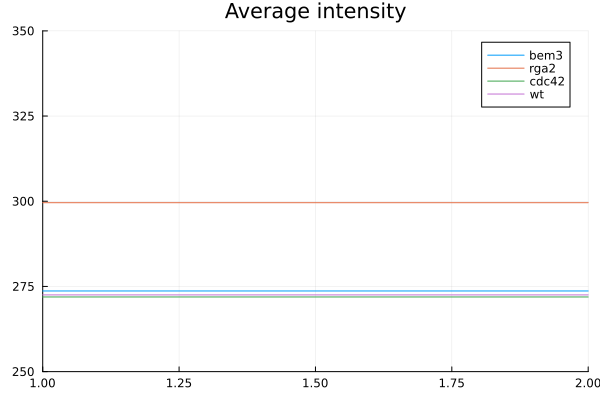

In [97]:
dir = "../data/movies-rga-bem3-cdc42/bem3/"
files = readdir(dir)
signals = zeros(length(files))
acs1 = zeros(length(files), 31)
pdgs1 = zeros(length(files), 32)

interval = 15
time_threshold=0.45

n=0
for f in files
    n+=1
    masks = mask_site("$dir$f", 0.5, n_sites=1);
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = maximum(m1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[times_max1] 
    signals[n] = mean(crop1)
    acs1[n, :] = crosscor(crop1, crop1, 0:30)
    pdg = DSP.Periodograms.periodogram(crop1)
    pdgs1[n, :] = pdg.power
end
t = range(0,60/interval*15)*(interval/60)
hline([mean(signals)], ylim=(0,500), label="bem3")

dir = "../data/movies-rga-bem3-cdc42/rga2/"
files = readdir(dir)
signals = zeros(length(files))
acs2 = zeros(length(files), 31)
pdgs2 = zeros(length(files), 32)
n=0
for f in files
    n+=1
    masks = mask_site("$dir$f", 0.5, n_sites=1);
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = maximum(m1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[times_max1] 
    signals[n] = mean(crop1)
    acs2[n, :] = crosscor(crop1, crop1, 0:30)
    pdg = DSP.Periodograms.periodogram(crop1)
    pdgs2[n, :] = pdg.power
end
t = range(0,60/interval*15)*(interval/60)
hline!([mean(signals)], ylim=(0,500), label="rga2")

dir = "../data/movies-rga-bem3-cdc42/cdc42/"
files = readdir(dir)
signals = zeros(length(files))
acs3 = zeros(length(files), 31)
pdgs3 = zeros(length(files), 32)
n=0
for f in files
    n+=1
    masks = mask_site("$dir$f", 0.5, n_sites=1);
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = maximum(m1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[times_max1]*(3/5) # used 5/3 the laser power for cdc42
    signals[n] = mean(crop1)
    acs3[n, :] = crosscor(crop1, crop1, 0:30)
    pdg = DSP.Periodograms.periodogram(crop1)
    pdgs3[n, :] = pdg.power
end
t = range(0,60/interval*15)*(interval/60)
hline!([mean(signals)], ylim=(0,500), label="cdc42")

freq = 0
dir = "../data/2024_09_26-3XGBwt/1patch/"
files = readdir(dir)
signals = zeros(length(files))
acs4 = zeros(length(files), 31)
pdgs4 = zeros(length(files), 32)
n=0
for f in files
    n+=1
    masks = mask_site("$dir$f", 0.5, n_sites=1);
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = maximum(m1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[times_max1]
    signals[n] = mean(crop1)
    acs4[n, :] = crosscor(crop1, crop1, 0:30)
    pdg = DSP.Periodograms.periodogram(crop1)
    pdgs4[n, :] = pdg.power
    freq = pdg.freq
end
t = range(0,60/interval*15)*(interval/60)
hline!([mean(signals)], ylim=(250,350), label="wt", title="Average intensity")


In [ ]:
plot(mean(acs1,dims=(1))[1,:], label="bem3")
plot!(mean(acs2,dims=(1))[1,:], label="rga2")
plot!(mean(acs3,dims=(1))[1,:], label="cdc42")
plot!(mean(acs4,dims=(1))[1,:], label="wt")

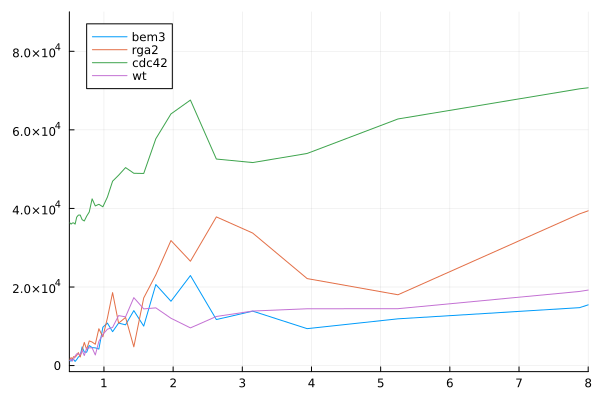

In [116]:
plot(1 ./ freq[2:end] * (15/60), mean(pdgs1,dims=(1))[1,2:end], label="bem3")
plot!(1 ./ freq[2:end] * (15/60),mean(pdgs2,dims=(1))[1,2:end], label="rga2")
plot!(1 ./ freq[2:end] * (15/60),mean(pdgs3,dims=(1))[1,2:end], label="cdc42")
plot!(1 ./ freq[2:end] * (15/60),mean(pdgs4,dims=(1))[1,2:end], label="wt")
plot!(xlim=(.5,8), xticks=[1,2,3,4,5,6,7,8])

In [91]:
range(0,31)

0:31